In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#@title Acceder al Drive

# monta Google Drive:
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/drive')

# directorio local en Google Drive
path = '/content/drive/MyDrive/'  #@param {type:"string"}


Mounted at /content/drive


In [ ]:
data_file = 'infoq_architecture_design_news_cleaned.csv'  #@param {type:"string"}
delimitador_columnas = ',' #@param {type:"string"}


In [ ]:
npr = pd.read_csv(path + data_file,
                  quotechar='"',
                  on_bad_lines='skip',
                  parse_dates=['Date'],
                  na_values=[],  # Trata las celdas vacías como cadenas vacías en lugar de NaN
                  keep_default_na=False)

In [ ]:
npr.head()

,Tag,Title,URL,Detail,Date,Author
0,Cloud,"AWS Sunsets More Services, Including AWS App M...",https://www.infoq.com/news/2024/10/aws-retires...,"In a series of blog posts, AWS has announced t...",2024-10-01,Renato Losio
1,Cloud,Amazon RDS for MySQL Zero-ETL Integration with...,https://www.infoq.com/news/2024/09/amazon-rds-...,Amazon RDS for MySQL's zero-ETL integration wi...,2024-09-30,Steef-Jan Wiggers
2,Java,Java News Roundup: Proposed Schedule for JDK 2...,https://www.infoq.com/news/2024/09/java-news-r...,"This week's Java roundup for September 23th, 2...",2024-09-30,Michael Redlich
3,Cloud,Cloud Misconfigurations Can Cause Major Data B...,https://www.infoq.com/news/2024/09/visibility-...,During her presentation at the inaugural editi...,2024-09-28,Olimpiu Pop
4,Architecture & Design,"Planning, Automation and Monorepo: How Monzo D...",https://www.infoq.com/news/2024/09/monzo-micro...,Monzo products are supported by an extensive m...,2024-09-28,Rafal Gancarz


In [ ]:
print(f"Corpus size: {len(npr)} documents")

Corpus size: 7575 documents


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
cv = CountVectorizer(max_df=0.9,min_df=2,stop_words='english')

In [ ]:
dtm = cv.fit_transform(npr['Detail'])

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

Results loaded from existing file.


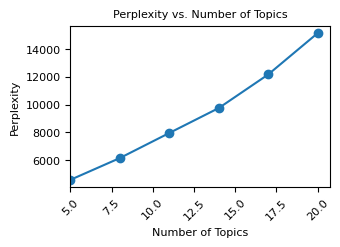

Number of Topics: 5, Perplexity: 4582.477188575578
Number of Topics: 8, Perplexity: 6149.391869707533
Number of Topics: 11, Perplexity: 7952.68113375375
Number of Topics: 14, Perplexity: 9747.96625582163
Number of Topics: 17, Perplexity: 12164.499805560195
Number of Topics: 20, Perplexity: 15139.931065044935


In [ ]:
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Results file
results_file = f'perplexities_{data_file}'

# Full path of results file
results_path = f'{path}{results_file}'

# Check if results file already exists
import os
if results_file in os.listdir(path):
    # Load existing results
    results = pd.read_csv(results_path)
    topic_range = results['Number of Topics'].values
    perplexities = results['Perplexity'].values
    print("Results loaded from existing file.")
else:
    # Split data into training and testing sets
    X_train, X_test = train_test_split(dtm, test_size=0.3, random_state=42)

    # Range of topic numbers to test
    topic_range = range(5, 21, 3)

    # Lists to store results
    perplexities = []

    for n_topics in tqdm(topic_range, desc="Training LDA models", unit="topics", bar_format="{l_bar}{bar}| {n}/{total} [{percentage:.0f}%] ({elapsed} elapsed, {remaining} remaining)"):
        # Train LDA model
        lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
        lda.fit(X_train)

        # Calculate perplexity
        perplexity = lda.perplexity(X_test)
        perplexities.append(perplexity)

    # Save results to CSV file
    results = pd.DataFrame({'Number of Topics': topic_range, 'Perplexity': perplexities})
    results.to_csv(results_path, index=False)
    print("Results saved to file.")

# Create figure with custom size
fig, ax = plt.subplots(figsize=(3.5, 2.5))

# Plot perplexity vs. number of topics
ax.plot(topic_range, perplexities, marker='o')
ax.set_xlabel('Number of Topics', fontsize=8)
ax.set_ylabel('Perplexity', fontsize=8)
ax.set_title('Perplexity vs. Number of Topics', fontsize=8)
ax.tick_params(axis='both', labelsize=8)
ax.xaxis.set_tick_params(rotation=45)
ax.set_xlim(left=5)  # Start x-axis at 5

plt.tight_layout()
plt.show()

# Print results
for n_topics, perplexity in zip(topic_range, perplexities):
    print(f'Number of Topics: {n_topics}, Perplexity: {perplexity}')

In [ ]:
number_of_topics = topic_range[np.argmin(perplexities)]
print(f'Número de Tópicos con menor Perplexity: {number_of_topics}')

Número de Tópicos con menor Perplexity: 5


In [ ]:
LDA = LatentDirichletAllocation(n_components=number_of_topics,random_state=42)

In [ ]:
LDA.fit(dtm)

LatentDirichletAllocation(n_components=5, random_state=42)

In [ ]:
import numpy as np

def display_topic_analysis(lda_model, feature_names, top_n=10):
    for idx, topic in enumerate(lda_model.components_):
        top_indices = topic.argsort()[:-top_n-1:-1]
        top_words = [feature_names[i] for i in top_indices]
        weights = topic[top_indices]
        percentages = (weights / weights.sum()) * 100

        print(f"Topic {idx}: {', '.join(top_words[:3])}")
        print(", ".join(f"{word} ({pct:.1f}%) " for word, pct in zip(top_words, percentages)))
        print()

# Example usage
display_topic_analysis(LDA, cv.get_feature_names_out())

Topic 0: software, soa, agile
software (15.7%) , soa (13.0%) , agile (12.0%) , development (9.3%) , conference (8.8%) , business (8.7%) , architecture (8.7%) , qcon (8.7%) , infoq (7.8%) , new (7.3%) 

Topic 1: java, spring, jdk
java (25.7%) , spring (17.0%) , jdk (9.9%) , week (9.0%) , features (8.6%) , release (7.3%) , news (6.4%) , apache (6.0%) , roundup (5.2%) , ee (5.0%) 

Topic 2: cloud, service, announced
cloud (15.0%) , service (11.8%) , announced (11.7%) , data (10.6%) , recently (9.8%) , aws (9.7%) , new (8.8%) , azure (7.8%) , amazon (7.6%) , microsoft (7.2%) 

Topic 3: ruby, language, infoq
ruby (23.7%) , language (11.9%) , infoq (11.0%) , languages (9.2%) , rails (8.2%) , using (7.9%) , programming (7.6%) , work (7.5%) , java (6.6%) , performance (6.5%) 

Topic 4: new, net, released
new (14.0%) , net (12.4%) , released (10.4%) , version (10.2%) , support (10.1%) , open (9.5%) , release (9.2%) , source (9.0%) , microsoft (8.3%) , announced (6.9%) 



In [ ]:
import numpy as np
from tabulate import tabulate

def display_topic_analysis(lda_model, feature_names, top_n=10):
    """
    Display LDA topic analysis results in IEEE paper format.

    Parameters:
    -----------
    lda_model : LatentDirichletAllocation
        Fitted LDA model
    feature_names : array-like
        List of feature names (words)
    top_n : int, optional (default=10)
        Number of top words to display per topic
    """
    for idx, topic in enumerate(lda_model.components_):
        # Get indices of top words in descending order
        top_indices = topic.argsort()[:-top_n-1:-1]

        # Get words and their weights
        top_words = [feature_names[i] for i in top_indices]
        weights = topic[top_indices]
        percentages = (weights / weights.sum()) * 100

        # Create table data
        table_data = []
        for rank, (word, weight, pct) in enumerate(zip(top_words, weights, percentages), 1):
            table_data.append([
                rank,
                word,
                f"{weight:.1f}",
                f"{pct:.1f}"
            ])

        # Print topic header and main theme
        print(f"\nTopic {idx} Analysis")
        print(f"Main theme: {', '.join(top_words[:3])}")
        print("-" * 60)

        # Print formatted table
        print(tabulate(
            table_data,
            headers=["Rank", "Keyword", "Weight", "Contribution (%)"],
            tablefmt="pipe",
            colalign=("right", "left", "right", "right"),
            floatfmt=".1f"
        ))
        print("\n")

# Example usage
display_topic_analysis(LDA, cv.get_feature_names_out())


Topic 0 Analysis
Main theme: software, soa, agile
------------------------------------------------------------
|   Rank | Keyword      |   Weight |   Contribution (%) |
|-------:|:-------------|---------:|-------------------:|
|      1 | software     |    714.0 |               15.7 |
|      2 | soa          |    591.2 |               13.0 |
|      3 | agile        |    546.6 |               12.0 |
|      4 | development  |    420.7 |                9.3 |
|      5 | conference   |    397.5 |                8.8 |
|      6 | business     |    396.2 |                8.7 |
|      7 | architecture |    395.5 |                8.7 |
|      8 | qcon         |    394.7 |                8.7 |
|      9 | infoq        |    353.9 |                7.8 |
|     10 | new          |    330.3 |                7.3 |



Topic 1 Analysis
Main theme: java, spring, jdk
------------------------------------------------------------
|   Rank | Keyword   |   Weight |   Contribution (%) |
|-------:|:----------|----

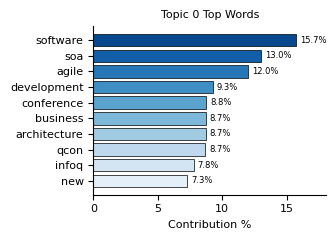

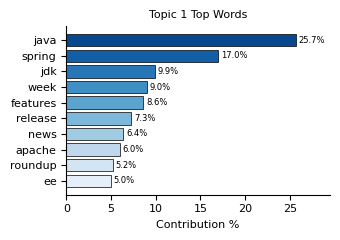

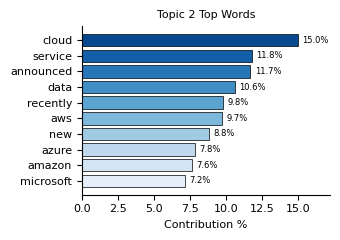

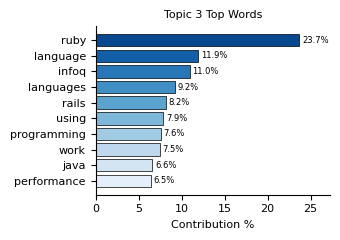

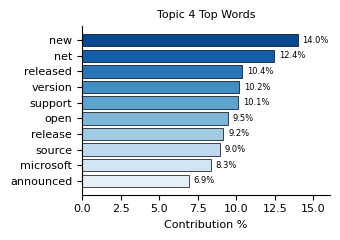

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_ieee_topic_words(lda_model, feature_names, topic_idx, top_n=10,
                         fig_width=3.5, fig_height=2.5):
    """
    Create IEEE-format compatible plot of top words for a given topic
    with right-aligned black percentage labels and thin black borders
    """
    # Get topic weights and words
    topic = lda_model.components_[topic_idx]
    top_indices = topic.argsort()[:-top_n-1:-1]
    top_words = [feature_names[i] for i in top_indices]
    weights = topic[top_indices]

    # Normalize weights to percentages
    weights = (weights / weights.sum()) * 100

    # Create horizontal bar plot with fixed IEEE dimensions
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Create color palette (dark to light blue) and reverse it
    colors = sns.color_palette("Blues", n_colors=len(weights))[::-1]

    # Plot bars with black edge
    bars = ax.barh(range(len(top_words)), weights, color=colors,
                   edgecolor='black', linewidth=0.5)  # Added black edge

    # Calculate the maximum width for consistent spacing
    max_width = max(weights)

    # Customize appearance
    ax.set_yticks(range(len(top_words)))
    ax.set_yticklabels(top_words, fontsize=8)
    ax.set_xlabel('Contribution %', fontsize=8)
    ax.set_title(f'Topic {topic_idx} Top Words', fontsize=8)

    # Set x-axis limits with padding for labels
    ax.set_xlim(0, max_width * 1.15)  # Add 15% padding for labels

    # Add percentage labels to the right of bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width + 0.3, bar.get_y() + bar.get_height()/2,
                f'{width:.1f}%',
                ha='left', va='center', fontsize=6,
                color='black')  # Black text

    # Invert y-axis to have highest percentages at the top
    ax.invert_yaxis()

    # Remove top and right spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Adjust layout
    ax.tick_params(axis='both', labelsize=8)
    plt.tight_layout()

    return fig, ax

# Use the function
for i in range(LDA.n_components):
    fig, ax = plot_ieee_topic_words(LDA, cv.get_feature_names_out(), i)
    plt.show()

In [ ]:
dtm

<7575x9183 sparse matrix of type '<class 'numpy.int64'>'
	with 172607 stored elements in Compressed Sparse Row format>

In [ ]:
topic_results = LDA.transform(dtm)

In [ ]:
topic_results.shape

(7575, 5)

In [ ]:
topic_results[0].round(2)

array([0.01, 0.01, 0.88, 0.01, 0.1 ])

In [ ]:
topic_results[0].argmax()

2

In [ ]:
npr.head()

,Tag,Title,URL,Detail,Date,Author
0,Cloud,"AWS Sunsets More Services, Including AWS App M...",https://www.infoq.com/news/2024/10/aws-retires...,"In a series of blog posts, AWS has announced t...",2024-10-01,Renato Losio
1,Cloud,Amazon RDS for MySQL Zero-ETL Integration with...,https://www.infoq.com/news/2024/09/amazon-rds-...,Amazon RDS for MySQL's zero-ETL integration wi...,2024-09-30,Steef-Jan Wiggers
2,Java,Java News Roundup: Proposed Schedule for JDK 2...,https://www.infoq.com/news/2024/09/java-news-r...,"This week's Java roundup for September 23th, 2...",2024-09-30,Michael Redlich
3,Cloud,Cloud Misconfigurations Can Cause Major Data B...,https://www.infoq.com/news/2024/09/visibility-...,During her presentation at the inaugural editi...,2024-09-28,Olimpiu Pop
4,Architecture & Design,"Planning, Automation and Monorepo: How Monzo D...",https://www.infoq.com/news/2024/09/monzo-micro...,Monzo products are supported by an extensive m...,2024-09-28,Rafal Gancarz


In [ ]:
topic_results.argmax(axis=1)

array([2, 2, 1, ..., 0, 0, 2])

In [ ]:
npr['Topic'] = topic_results.argmax(axis=1)

In [ ]:
npr.head(100)

,Tag,Title,URL,Detail,Date,Author,Topic
0,Cloud,"AWS Sunsets More Services, Including AWS App M...",https://www.infoq.com/news/2024/10/aws-retires...,"In a series of blog posts, AWS has announced t...",2024-10-01,Renato Losio,2
1,Cloud,Amazon RDS for MySQL Zero-ETL Integration with...,https://www.infoq.com/news/2024/09/amazon-rds-...,Amazon RDS for MySQL's zero-ETL integration wi...,2024-09-30,Steef-Jan Wiggers,2
2,Java,Java News Roundup: Proposed Schedule for JDK 2...,https://www.infoq.com/news/2024/09/java-news-r...,"This week's Java roundup for September 23th, 2...",2024-09-30,Michael Redlich,1
3,Cloud,Cloud Misconfigurations Can Cause Major Data B...,https://www.infoq.com/news/2024/09/visibility-...,During her presentation at the inaugural editi...,2024-09-28,Olimpiu Pop,0
4,Architecture & Design,"Planning, Automation and Monorepo: How Monzo D...",https://www.infoq.com/news/2024/09/monzo-micro...,Monzo products are supported by an extensive m...,2024-09-28,Rafal Gancarz,2
...,...,...,...,...,...,...,...
95,Cloud,.NET Inline C# Action Feature in Logic Apps: M...,https://www.infoq.com/news/2024/06/logic-app-i...,Microsoft has announced a significant enhancem...,2024-06-18,Steef-Jan Wiggers,2
96,Java,"Java News Roundup: Keycloak 25, Jakarta EE 11 ...",https://www.infoq.com/news/2024/06/java-news-r...,"This week's Java roundup for June 10th, 2024, ...",2024-06-17,Michael Redlich,1
97,Cloud,Amazon EC2 U7i Instances: 896 vCPUs and up to ...,https://www.infoq.com/news/2024/06/aws-ec2-u7i...,AWS recently announced the general availabilit...,2024-06-15,Renato Losio,2
98,Cloud,Increased Popularity of Artist Platform Cara L...,https://www.infoq.com/news/2024/06/vercel-serv...,"Cara's web and mobile app, a platform for arti...",2024-06-14,Steef-Jan Wiggers,2


In [ ]:
print(npr['Date'].dtype)

datetime64[ns]


In [ ]:
npr['Date'] = pd.to_datetime(npr['Date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [ ]:
print(npr['Date'].isna().sum())

0


In [ ]:
npr['Year'] = npr['Date'].dt.year
npr['Month'] = npr['Date'].dt.month
npr['Day'] = npr['Date'].dt.day
npr['Hour'] = npr['Date'].dt.hour
npr['Quarter'] = npr['Date'].dt.to_period('Q')

In [ ]:
# @title
print(npr[['Date', 'Year', 'Month', 'Day', 'Hour', 'Quarter']].head())

        Date  Year  Month  Day  Hour Quarter
0 2024-10-01  2024     10    1     0  2024Q4
1 2024-09-30  2024      9   30     0  2024Q3
2 2024-09-30  2024      9   30     0  2024Q3
3 2024-09-28  2024      9   28     0  2024Q3
4 2024-09-28  2024      9   28     0  2024Q3


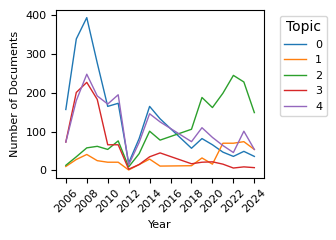

Topic Evolution Table:
Topic    0   1    2    3    4
Year                         
2006   157  10   13   73   73
2007   339  28   35  201  180
2008   394  41   58  227  248
2009   277  25   62  183  192
2010   165  21   54   66  171
2011   173  21   76   66  195
2012    19   1    9    3   14
2013    82  15   43   15   72
2014   165  29  101   35  146
2015   133  11   78   45  125
2018    57  12  106   17   74
2019    82  32  188   21  110
2020    66  16  162   22   85
2021    47  70  199   16   64
2022    36  70  245    6   46
2023    49  74  228    9  101
2024    36  54  149    7   54


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Add year column
npr['Year'] = npr['Date'].dt.year

# Filter by date if necessary
npr_filtered = npr[npr['Date'] > '2020-01-01']

# Diachronic analysis after topic modeling
topic_results = LDA.transform(dtm)
npr['Topic'] = topic_results.argmax(axis=1)

# Count topics by year
topic_counts_by_year = npr.groupby(['Year', 'Topic']).size().unstack(fill_value=0)

# Visualize topic evolution over time
fig, ax = plt.subplots(figsize=(3.5, 2.5))  # Ajustado para IEEE

topic_counts_by_year.plot(kind='line', ax=ax, linewidth=1)  # Ajustado para IEEE

# Format x-axis to show only integer years
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.tick_params(axis='both', labelsize=8)  # Ajusta tamaño de números en ejes
ax.xaxis.set_tick_params(rotation=45)  # Rotar etiquetas de años para evitar superposición

plt.xlabel('Year', fontsize=8)
plt.ylabel('Number of Documents', fontsize=8)
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)  # Ajustado para IEEE
plt.tight_layout()

plt.show()

# Print table data separately
print("Topic Evolution Table:")
print(topic_counts_by_year)

In [ ]:
import yaml

# Load explainability terms from YAML file
with open('/content/drive/MyDrive/Tesis/params.yaml', 'r') as f:
    params = yaml.safe_load(f)

explainability_keywords = params['explainability_terms']
explainability_keywords = [term.lower() for term in explainability_keywords]

print("Explainability Keywords:")
print(explainability_keywords)

# Identify explainability topics (assuming LDA components are already computed)
explainability_topics = []
for index, topic in enumerate(LDA.components_):
    top_words = [cv.get_feature_names_out()[i] for i in topic.argsort()[-50:]]
    if any(term in top_words for term in explainability_keywords):
        explainability_topics.append(index)

print("\nPotential explainability topics:", explainability_topics)

Explainability Keywords:
['explain', 'interpret', 'transparent', 'black-box', 'white-box', 'explainable', 'interpretable', 'explainability', 'interpretability', 'resolvable', 'resolvability', 'explicable', 'explicability', 'answerable', 'answerability', 'feasible', 'feasibility', 'solvable', 'solvability', 'accountability', 'outline', 'traceability', 'describe', 'observability', 'observe', 'monitor', 'trace']

Potential explainability topics: []


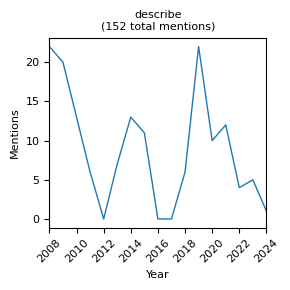

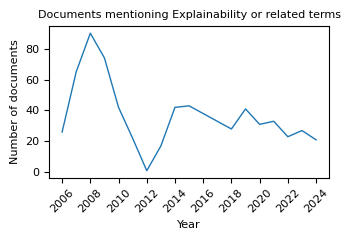

explainability_docs_over_time.csv:
Year,0
2006,26
2007,65
2008,90
2009,74
2010,42
2011,22
2012,1
2013,17
2014,42
2015,43
2018,28
2019,41
2020,31
2021,33
2022,23
2023,27
2024,21




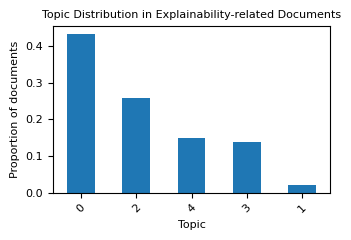

explainability_topic_dist.csv:
Topic,proportion
0,0.4329073482428115
2,0.25878594249201275
4,0.1485623003194888
3,0.1389776357827476
1,0.020766773162939296




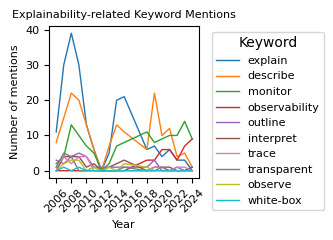

keyword_mentions_over_time.csv:
Year,explain,describe,monitor,observability,outline,interpret,trace,transparent,observe,white-box
2006,11,8,2,0,3,0,1,1,0,0
2007,30,15,4,0,2,4,4,5,2,1
2008,39,22,13,0,4,4,2,4,3,0
2009,30,20,10,0,5,4,4,0,3,1
2010,13,13,7,0,4,1,4,0,0,0
2011,6,6,5,0,1,2,0,1,1,0
2012,0,0,0,0,1,0,0,0,0,0
2013,5,7,2,0,1,1,0,0,1,0
2014,20,13,7,0,1,2,0,0,0,0
2015,21,11,8,0,1,3,0,1,2,0
2018,6,6,11,3,1,0,0,0,1,0
2019,7,22,8,3,3,1,1,0,0,0
2020,4,10,9,6,0,1,1,1,0,0
2021,6,12,10,6,0,1,0,0,0,0
2022,3,4,10,3,1,0,1,0,0,0
2023,3,5,14,7,0,0,1,0,0,0
2024,0,1,9,9,1,1,0,0,0,0




In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd

# Find documents containing explainability-related keywords
explainability_docs = npr[npr['Detail'].str.contains('|'.join(explainability_keywords), case=False)]

# Analyze the evolution of mentions over time
fig, ax = plt.subplots(figsize=(3.5, 2.5))
explainability_docs_over_time = explainability_docs.groupby('Year').size()
explainability_docs_over_time.plot(kind='line', ax=ax, linewidth=1)
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.tick_params(axis='both', labelsize=8)
ax.xaxis.set_tick_params(rotation=45)
plt.title('Documents mentioning Explainability or related terms', fontsize=8)
plt.xlabel('Year', fontsize=8)
plt.ylabel('Number of documents', fontsize=8)
plt.tight_layout()
plt.show()

# Print the data as a CSV to the console
print('explainability_docs_over_time.csv:')
print(explainability_docs_over_time.to_csv())
print()

# Analyze the distribution of topics in these documents
fig, ax = plt.subplots(figsize=(3.5, 2.5))
explainability_topic_dist = explainability_docs['Topic'].value_counts(normalize=True)
explainability_topic_dist.plot(kind='bar', ax=ax)
ax.tick_params(axis='both', labelsize=8)
ax.xaxis.set_tick_params(rotation=45)
plt.title('Topic Distribution in Explainability-related Documents', fontsize=8)
plt.xlabel('Topic', fontsize=8)
plt.ylabel('Proportion of documents', fontsize=8)
plt.tight_layout()
plt.show()

# Print the data as a CSV to the console
print('explainability_topic_dist.csv:')
print(explainability_topic_dist.to_csv())
print()

# Analyze the evolution of specific keyword mentions
fig, ax = plt.subplots(figsize=(3.5, 2.5), gridspec_kw={'width_ratios': [1.2]})
keyword_mentions = pd.DataFrame({keyword: npr['Detail'].str.contains(keyword, case=False).astype(int) for keyword in explainability_keywords})
keyword_mentions_over_time = keyword_mentions.groupby(npr['Year']).sum()
top_10_keywords = keyword_mentions.sum().nlargest(10).index
keyword_mentions_over_time[top_10_keywords].plot(ax=ax, linewidth=1)
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.tick_params(axis='both', labelsize=8)
ax.xaxis.set_tick_params(rotation=45)
plt.title('Explainability-related Keyword Mentions', fontsize=8)
plt.xlabel('Year', fontsize=8)
plt.ylabel('Number of mentions', fontsize=8)
plt.legend(title='Keyword', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

# Print the data as a CSV to the console
print('keyword_mentions_over_time.csv:')
print(keyword_mentions_over_time[top_10_keywords].to_csv())
print()

Keywords data loaded from existing file.


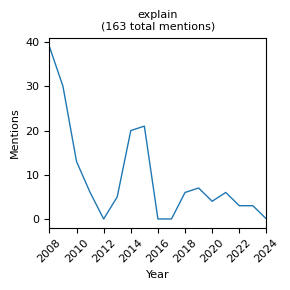

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import math
import os
from tqdm import tqdm

# Results file
keywords_file = f'keywords_data_{data_file}'

# Full path of results file
keywords_path = f'{path}{keywords_file}'

# Check if keywords file already exists
if keywords_file in os.listdir(path):
    # Load existing results
    keywords_data = pd.read_csv(keywords_path)
    print("Keywords data loaded from existing file.")
else:
    # Create a DataFrame to store mentions of each keyword over time
    keywords_data = pd.DataFrame()

    # Ensure we have all years from 2008 to 2024
    full_year_range = pd.DataFrame({'Year': range(2008, 2025)})

    # For each keyword, count mentions per year
    for keyword in tqdm(explainability_keywords, desc="Processing keywords"):
        yearly_counts = npr[npr['Detail'].str.contains(keyword, case=False)].groupby('Year').size()
        # Convert to DataFrame and merge with full year range to ensure all years are present
        keyword_df = pd.DataFrame(yearly_counts).reset_index()
        keyword_df.columns = ['Year', keyword]
        full_data = pd.merge(full_year_range, keyword_df, on='Year', how='left')
        keywords_data[keyword] = full_data[keyword].fillna(0)

    # Add Year column
    keywords_data['Year'] = range(2008, 2025)

    # Save to CSV
    keywords_data.to_csv(keywords_path, index=False)
    print("Keywords data saved to file.")

# Calculate total mentions for each keyword to determine order
keyword_totals = {col: keywords_data[col].sum() for col in keywords_data.columns if col != 'Year'}
sorted_keywords = sorted(keyword_totals.items(), key=lambda x: x[1], reverse=True)

# Create plots in series of 3
plt.ioff()  # Turn off interactive mode
for i in range(0, len(sorted_keywords), 3):
    # Create a batch of up to 3 plots
    batch_keywords = sorted_keywords[i:i+3]

    # Create the plots for this batch
    for j, (keyword, total) in enumerate(batch_keywords):
        fig, ax = plt.subplots(figsize=(3, 3))

        # Plot data without label
        keywords_data.plot(x='Year', y=keyword, ax=ax, linewidth=1, label='')
        ax.set_title(f'{keyword}\n({total:.0f} total mentions)', fontsize=8)
        ax.set_xlabel('Year', fontsize=8)
        ax.set_ylabel('Mentions', fontsize=8)
        ax.tick_params(axis='both', labelsize=8)

        # Set x-axis range and ticks
        ax.set_xlim(2008, 2024)
        ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
        ax.xaxis.set_tick_params(rotation=45)

        # Remove legend
        ax.get_legend().remove()

        plt.tight_layout()

        # Save the plot
        plot_filename = f'{path}keyword_plot_{keyword.replace(" ", "_")}.png'
        plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

    # Add a newline after each batch of 3
    if i + 3 < len(sorted_keywords):
        print("\n")

plt.ion()  # Turn interactive mode back on

# Print summary statistics for each keyword in order
print("\nSummary Statistics (ordered by total mentions):")
for keyword, total in sorted_keywords:
    max_mentions = keywords_data[keyword].max()
    # Safe way to find the year of maximum mentions
    if max_mentions > 0:  # Only find max year if there are mentions
        max_year = keywords_data.loc[keywords_data[keyword] == max_mentions, 'Year'].iloc[0]
    else:
        max_year = "No mentions"

    print(f"\n{keyword}:")
    print(f"Total mentions: {total:.0f}")
    print(f"Peak mentions: {max_mentions:.0f} (Year: {max_year})")

In [ ]:
for idx, topic in enumerate(LDA.components_):
    topic_words = [cv.get_feature_names_out()[i] for i in topic.argsort()[-100:]]
    explainable_words = [word for word in topic_words if word in explainability_keywords]
    print(f"Tópico {idx + 1} - Palabras relacionadas con explainability: {explainable_words}")

# Análisis de co-ocurrencia
from sklearn.feature_extraction.text import CountVectorizer

# Crear un nuevo vectorizador que incluya los términos de explainability
cv_explain = CountVectorizer(vocabulary=explainability_keywords)
dtm_explain = cv_explain.fit_transform(npr['Detail'])

# Calcular la co-ocurrencia
co_occurrence = (dtm.T @ dtm_explain).toarray()

# Mostrar las 10 palabras que más co-ocurren con cada término de explainability
for idx, keyword in enumerate(explainability_keywords):
    top_co_words = [cv.get_feature_names_out()[i] for i in co_occurrence[:, idx].argsort()[-10:]]
    print(f"Palabras que co-ocurren con '{keyword}': {top_co_words}")